## Setup

In [ ]:
! brew install git python3 cmake sdl2 sdl2_image sdl2_ttf sdl2_gfx boost boost-python3
! python3 -m pip install --upgrade pip setuptools psutil wheel

In [ ]:
! pip install gfootball 

In [ ]:
! pip install setuptools==65.5.0
! git clone https://github.com/google-research/football.git
! cd football && pip install . 

### Test game play

In [127]:
! python -m gfootball.play_game --action_set=full

objc[81026]: Class SDLApplication is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368800) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321287e8). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLAppDelegate is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368850) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x132128838). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLTranslatorResponder is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x1063688c8) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321288b0). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLMessageBoxPresenter is implemented in both /opt/h

### Learning environment 

In [172]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import numpy as np
import os
from collections import namedtuple
import gfootball
import gfootball.env as football_env
from gfootball.env.wrappers import Simple115StateWrapper
import collections

class ShapingRewardWrapper(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self.observation_space = collections.namedtuple('ObservationSpace', 'shape')
            self.observation_space.shape=(115,)
            self._env = env

            self._bo = 0.02
            
            # attack vs defense coefficients
            self._dist_mg = 0.01
            self._dist_og = 0.01
            
            self._opdist = 0.1
            self._goal_bonus = 100

        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward *= self._goal_bonus
            obs = obs[0]

            if obs['ball_owned_team'] == 0:
                reward += self._bo
            elif obs['ball_owned_team'] == 1:
                reward -= self._bo

            bx, by, bz = obs['ball']
            mgx, mgy = -1, 0
            ogx, ogy = 1, 0
            
            dist_from_my_goal = (np.sqrt((bx-mgx)**2 + (by-mgy)**2))
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            
            reward += self._dist_mg * dist_from_my_goal
            reward += self._dist_og * dist_from_opponent_goal

            # distance of controlling player from ball 
            mx, my = obs['left_team'][obs['active']]
            if obs['ball_owned_team'] != 0:
                reward -= self._opdist * (np.sqrt((bx-mx)**2 + (by-my)**2))
                
            return obs, reward, done, info

        
def obs_transform(obs):
    return Simple115StateWrapper.convert_observation(obs, True)


def create_env(render=False, 
               env_name='academy_empty_goal', 
               wrapper_init=None,
               record=True,
               **params):
    if env_name == 'cart_pole':
        env = gym.make('CartPole-v0')
    else:
        env_names = ['1_vs_1_easy', '5_vs_5', 'academy_run_to_score', 'academy_empty_goal_close', 'academy_empty_goal']
        os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
        env = football_env.create_environment(env_name=env_name, 
                                              stacked=False, 
                                              representation='raw',
                                              rewards='scoring,checkpoints',
                                              logdir='/Users/georgipachov/Dev/gym-soccer', 
                                              write_goal_dumps=record, 
                                              write_full_episode_dumps=record, 
                                              write_video=record,
                                              render=render)
        if wrapper_init is not None:
            return wrapper_init.__call__(env)
        else:
            return env


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(115, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 19)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


def select_action(model, state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    return action.item()


def finish_episode(model, optimizer, gamma):
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


### Learning objective: learn penalty/shooting

In [164]:
class DistanceFromOpponentGoalReward(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = -1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info

In [210]:
def run_agent(exp_name='exp1',
              model=None,
              train=True,
              render=False,
              record=False, 
              num_episodes=2000,
              num_steps=500,
              task='academy_empty_goal_close',
              wrapper_init=DistanceFromOpponentGoalReward,
              policy_fn=Policy,
              solved_threshold=-25,
              log_every=50,
              learning_rate=1e-2,
              gamma=0.99,
              last_n=5,
              seed=0,
             ):
    # set seed first
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    try: 
        running_reward = 0
        episode_rewards = []
        env = create_env(render=render, 
                         env_name=task,
                         record=record,
                         wrapper_init=DistanceFromOpponentGoalReward)
        if model is None:
            model = policy_fn()
            
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        eps = np.finfo(np.float32).eps.item()

        # run inifinitely many episodes
        for i_episode in range(num_episodes):
            # reset environment and episode reward
            state = env.reset()
            state = obs_transform(state)
            ep_reward = 0

            # for each episode, only run 9999 steps so that we don't 
            # infinite loop while learning
            for t in range(1, num_steps):

                # select action from policy
                action = select_action(model, state)

                # take the action
                state, reward, done, _ = env.step(action)
                state = obs_transform([state])

                model.rewards.append(reward)
                ep_reward += reward
                if done:
                    break

            # update cumulative reward
            running_reward = np.mean(episode_rewards[-last_n:])
            
            # log results
            episode_rewards.append(ep_reward)
            if i_episode % log_every == 0:
                print(f'Episode: {i_episode}\tLast reward: {ep_reward:.2f} \t Last {last_n} episodes average reward: {running_reward}')

            if train:
                # perform backprop
                finish_episode(model, optimizer, gamma)

                if i_episode > last_n and running_reward > solved_threshold:
                    torch.save(model, f'{task}_{exp_name}.h5')
                    print('Solved!')
                    return model, episode_rewards
                
        return model, episode_rewards
    finally: 
        env.close()

In [214]:
model, episode_rewards = run_agent(train=True, render=False, record=False, log_every=10, seed=42, last_n=20)

Episode: 0	Last reward: -132.79 	 Last 20 episodes average reward: nan


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_87348/3340386536.py:168: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode: 10	Last reward: -202.97 	 Last 20 episodes average reward: -129.52103492528263
Episode: 20	Last reward: -397.98 	 Last 20 episodes average reward: -134.905737461156
Episode: 30	Last reward: -35.36 	 Last 20 episodes average reward: -145.7993906186256
Episode: 40	Last reward: -260.32 	 Last 20 episodes average reward: -138.98659219655462
Episode: 50	Last reward: -32.81 	 Last 20 episodes average reward: -110.48746721646262
Episode: 60	Last reward: -131.50 	 Last 20 episodes average reward: -76.7861424600026
Episode: 70	Last reward: -40.46 	 Last 20 episodes average reward: -51.40812302898756
Episode: 80	Last reward: -98.65 	 Last 20 episodes average reward: -34.713558500079216
Episode: 90	Last reward: -21.22 	 Last 20 episodes average reward: -28.127986921104245
Episode: 100	Last reward: -26.53 	 Last 20 episodes average reward: -26.619671594054914
Solved!


<AxesSubplot: xlabel='episode', ylabel='reward'>

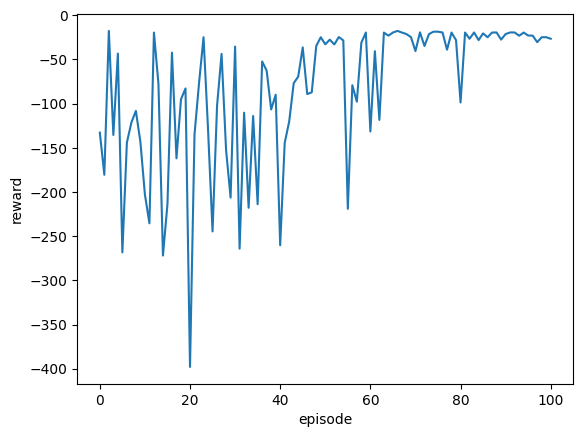

In [221]:
pd.Series(episode_rewards[:-1]).plot(xlabel='Еpisode', ylabel='Reward')

In [218]:
run_agent(model=model, train=False, render=True, record=True, num_episodes=1)

Episode: 0	Last reward: -28.32 	 Last 5 episodes average reward: nan


(Policy(
   (affine1): Linear(in_features=115, out_features=128, bias=True)
   (action_head): Linear(in_features=128, out_features=19, bias=True)
   (value_head): Linear(in_features=128, out_features=1, bias=True)
 ),
 [-28.31679495782684])

In [148]:
# https://github.com/google-research/football/blob/master/gfootball/doc/observation.md#raw-observations

### Visualize network

In [ ]:
! brew install graphviz
! pip install torchviz

In [229]:
model

Policy(
  (affine1): Linear(in_features=115, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=19, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

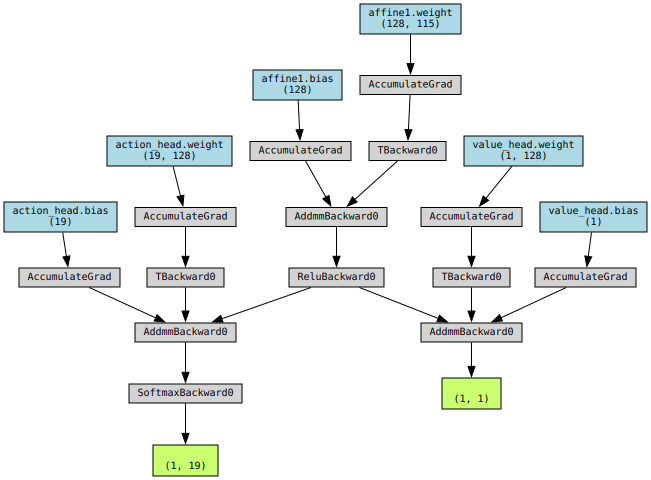

In [227]:
from torchviz import make_dot
state_torch = torch.from_numpy(state).float()
probs, state_value = model(state_torch)
make_dot((probs, state_value), params=dict(model.named_parameters()))

### Learning env 2

In [16]:
#!/usr/bin/env python3
import gym
from collections import namedtuple
import numpy as np
import traceback
from multiprocessing import Lock
import json
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as multiprocessing
from torch.multiprocessing import Pool
import collections
import time
import gfootball
import os
import gfootball.env as football_env
from gfootball.env.wrappers import Simple115StateWrapper
import matplotlib.pyplot as plt


class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

    

class ShapingRewardWrapper(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self.observation_space = collections.namedtuple('ObservationSpace', 'shape')
            self.observation_space.shape=(115,)
            self._env = env

            self._bo = 0.02
            
            # attack vs defense coefficients
            self._dist_mg = 0.01
            self._dist_og = 0.01
            
            self._opdist = 0.1
            self._goal_bonus = 100

        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward *= self._goal_bonus
            obs = obs[0]

            if obs['ball_owned_team'] == 0:
                reward += self._bo
            elif obs['ball_owned_team'] == 1:
                reward -= self._bo

            bx, by, bz = obs['ball']
            mgx, mgy = -1, 0
            ogx, ogy = 1, 0
            
            dist_from_my_goal = (np.sqrt((bx-mgx)**2 + (by-mgy)**2))
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            
            reward += self._dist_mg * dist_from_my_goal
            reward += self._dist_og * dist_from_opponent_goal

            # distance of controlling player from ball 
            mx, my = obs['left_team'][obs['active']]
            if obs['ball_owned_team'] != 0:
                reward -= self._opdist * (np.sqrt((bx-mx)**2 + (by-my)**2))
                
            return obs, reward, done, info


def obs_transform(obs):
    return Simple115StateWrapper.convert_observation(obs, True)

def iterate_batches(env, net, batch_size, max_steps):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()   
    obs = obs_transform(obs)
    sm = nn.Softmax(dim=1)
    current_step = 0
    while True:
        obs_v = torch.FloatTensor(obs)
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        next_obs = obs_transform([next_obs])
        episode_reward += reward
        episode_steps.append((obs, action))
        
        if max_steps and current_step > max_steps:
            is_done = True
        
        current_step += 1
            
        if is_done:
            batch.append((episode_reward, episode_steps))
            episode_reward = 0.0
            episode_steps = []
            current_step = 0
            next_obs = obs_transform(env.reset())
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs


def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s[0], batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    elite_batch = []
    for example in batch:
        if example[0] < reward_bound:
            continue
        train_obs.extend(map(lambda step: step[0], example[1]))
        train_act.extend(map(lambda step: step[1], example[1]))
    elite_batch.append(example)

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return elite_batch, train_obs_v, train_act_v, reward_bound, reward_mean

def create_env(render=False, env_name='academy_empty_goal', **params):
    if env_name == 'cart_pole':
        env = gym.make('CartPole-v0')
    else:
        env_names = ['1_vs_1_easy', '5_vs_5', 'academy_run_to_score', 'academy_empty_goal_close', 'academy_empty_goal']
        os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
        env = football_env.create_environment(env_name=env_name, 
                                              stacked=False, 
                                              representation='raw',
                                              rewards='scoring,checkpoints',
                                              logdir='/tmp/football', 
                                              write_goal_dumps=False, 
                                              write_full_episode_dumps=False, 
                                              write_video=False,
                                              render=render)

        env = ShapingRewardWrapper(env)
    return env

def analyse_trends(training_history, loss_history):
    # Explore rewards after playing
    if training_history and len(training_history) > 0:
        plt.plot(training_history)
        plt.ylabel('Episode Reward')
        plt.show()

    if loss_history and len(loss_history):
        plt.plot(loss_history)
        plt.ylabel('categorical_crossentropy')
        plt.show()


# Training loop
def play(env, model, opt, ce, 
         id=-1,
         num_eps=1000, 
         threshold=0.5, 
         action='sample', 
         epsilon=0.1,  
         batch_size=10, 
         obs_transform=None, 
         shape_fix=True,
         max_steps=1500,
         report_interval=5,
         train=True,
         print_rew=True,
         **config):
    
    loss_history = []
    training_history = []
    max_rew = 0
    sm = nn.Softmax(dim=1)

    try:
        for e in range(num_eps):
            episodes = []
            t = time.time()
            for _ in range(batch_size):
                if e == 0 and _ == 0:
                    print('Start training...')
                    
                obs = env.reset()
                if obs_transform:
                    obs = obs_transform(obs)
                episode = []
                total_reward = 0
                step = 0
                while True:
                    # Sample from model
                    torch_obs = torch.FloatTensor(obs)
                    out = sm(model(torch_obs)).data.numpy()[0]
                    a = np.random.choice(a=len(out), p=out)

                    new_obs, rew, done, info = env.step(a)
                    
                    total_reward += rew

                    ep_action = np.zeros_like(out)
                    ep_action[a] = 1
                    episode.append((obs, ep_action, rew))
                    
                    if obs_transform:
                        new_obs = obs_transform([new_obs]) # Fix for environment bug
                        
                    obs = new_obs
                    
                    step +=1

                    if done or step > max_steps:
                        print(total_reward)
                        episodes.append(episode)
                        training_history.append(total_reward)
                        break
                        
            elapsed = time.time() - t
            rew = np.mean(training_history[-batch_size:])
                
            print(f'Batch {e} mean reward: {rew}, took {elapsed}')
            if e % report_interval == 0:
                print(f'{id}: {e} - results:')
                if training_history and len(training_history) > 0:
                    t = np.array(np.array_split(training_history, int(len(training_history)/batch_size))).mean(axis=1)
                    plt.title(id)
                    pd.Series(t).plot()
                    plt.show()
                
                if loss_history and len(loss_history):
                    plt.plot(loss_history)
                    plt.ylabel('categorical_crossentropy')
                    plt.show()
                
            # Train for filtered episodes
            f_eps = np.array(filter_episodes(episodes, t=threshold))
            print(f'Training on {len(f_eps)} with mean reward: {np.mean([np.sum([t[2] for t in e]) for e in f_eps])}')
            if shape_fix:
                all_obs = np.array([x[0][0] for e in f_eps for x in e])
            else:
                all_obs = np.array([x[0] for e in f_eps for x in e])    
            
            all_logits = np.array([x[1] for e in f_eps for x in e])
            all_rew = np.array([x[2] for e in f_eps for x in e])
            if train:
                opt.zero_grad()
                all_obs_torch = torch.FloatTensor(all_obs)
                labels = all_logits.max(axis=1)
                all_logits_torch = torch.LongTensor(labels)
                model_logits = model(all_obs_torch)
                loss_v = ce(model_logits, all_logits_torch)
                loss_v.backward()
                loss_history.append(loss_v.data.numpy())
                opt.step()
    except KeyboardInterrupt:
        pass
    except Exception:
        traceback.print_exc()
    finally:
        pass
                        
    return training_history, loss_history

def run_exp(name, params, proc=None):
    if not proc:
        proc = multiprocessing.cpu_count()
    os.makedirs('experiments', exist_ok=True)
    
    _id = 0
    for p in params:
        p['id'] = f'{name}_{_id}'
        _id += 1
        
    with Pool(proc) as p:
        res = p.map(exp, params)

    for t_hist, l_hist, params in res:
        plt.title(params)
        analyse_trends(t_hist, l_hist)    
        plt.show()
    return res

def exp(params):
    try:
        env = create_env(**params)
        model, opt, ce = create_model(env=env, **params)
        t_hist, l_hist = play(env=env, 
                              model=model, 
                              opt=opt, 
                              ce=ce, 
                              **params)
        return t_hist, l_hist, params
    except Exception as e:
        traceback.print_exc()
        print(e)
    finally: 
        print(f'Saving {params["id"]}.h5 for param_set {params}')
        torch.save(model, f'experiments/{params["id"]}.h5')
        env.close()
        

def train(exp_name='',
          id=0,
          env_name='academy_empty_goal_close', 
          hidden_size=128,
          train_steps=50, 
          batch_size=16, 
          lr=0.01, 
          percentile=70, 
          solve_threshold=100, 
          save_threshold=0,
          max_steps=10000,
          experience_replay=4,
          exp_replay = 'experience.json',
          **params):
    print(f'Starting {exp_name}_{id}')
    global lock
    assert lock is not None
    env = create_env(env_name=env_name, params={})
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    net = Net(obs_size, hidden_size, n_actions)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=lr)
    t_hist = []
    l_hist = []
    
    last_model = None
    reward_best = 0
    full_batch = []
    for iter_no, batch in enumerate(iterate_batches(env, net, batch_size, max_steps)):
        # Train
        with lock:
            if os.path.exists(exp_replay):
                with open(exp_replay, 'r') as e:
                    full_batch = json.load(e)
           
        full_batch, obs_v, acts_v, reward_b, reward_m = filter_batch(full_batch + batch, percentile)
        print(len(full_batch))
        with lock:
            with open(exp_replay, 'w+') as e:
                full_batch = sorted(full_batch, key=lambda episode: episode[0])
                full_batch = full_batch[-experience_replay:]
                json.dump(full_batch, e, default=default)

        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        action_scores_v = torch.reshape(action_scores_v, (action_scores_v.shape[0], action_scores_v.shape[2]))
        loss_v = objective(action_scores_v, acts_v)
        loss_v.backward()
        optimizer.step()
        print("%s-%s %d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (exp_name, id, iter_no, loss_v.item(), reward_m, reward_b))
        l_hist.append(loss_v.item())
        t_hist.append((reward_m, reward_b))
        
        # Save 
        if reward_m > solve_threshold:
            print("Solved!")
            last_model = f'experiments/{exp_name}_{reward_m}.h5'
            torch.save(net, f'experiments/{exp_name}_{reward_m}.h5')
            return id, t_hist, l_hist, last_model
        if reward_m > save_threshold and reward_m > reward_best:
            last_model = f'experiments/{exp_name}_{reward_m}.h5'
            torch.save(net, last_model)
            reward_best = reward_m
        if iter_no > train_steps:
            return id, t_hist, l_hist, last_model


def exp(paramset):
    return train(**paramset)

def init(l):
    global lock
    lock = l


def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

def run(params, proc=None):
    if not proc:
        proc = multiprocessing.cpu_count()
    os.makedirs('experiments', exist_ok=True)
    
    _id = 0
    lock = Lock()
    for p in params:
        p['id'] = f'{p["exp_name"]}_{_id}'
        _id += 1
    
        
    with Pool(proc, initializer=init, initargs=(lock,)) as p:
        res = p.map(exp, params)

    for id, t_hist, l_hist, model_name in res:
        plt.title(id)
        analyse_trends(t_hist, l_hist)    
        plt.show()
    return res

In [ ]:
# Configuration sheet
params = [{'exp_name': 'long-eps-b32', 'env_name': '11_vs_11_kaggle', 'train_steps': 100, 'percentile': 50, 'lr': 0.1, 'max_steps': 100, 'batch_size': 2, 'solve_threshold': 150},
          {'exp_name': 'long-eps-b32', 'env_name': '11_vs_11_kaggle', 'train_steps': 100, 'percentile': 50, 'lr': 0.1, 'max_steps': 100, 'batch_size': 2, 'solve_threshold': 150},]

model_path = run(params)
